<h1>High spectral variability regions coverage simulation</h1>
<p style="font-size:150%;">Imports and functions</p>

In [235]:
#Path
import sys

#Python lib
import numpy as np
import pandas as pd

#Maps and sky
import healpy as hp

#Plots
import matplotlib
import matplotlib.pyplot as plt

#Astropy
import astropy.coordinates as coord
from astropy import units as u
from astropy.coordinates import SkyCoord

#Scanning strategy
import QubicObservation as qobs

#Qubic
from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene  
from qubic.lib.Qsamplings import QubicSampling 
from qubic.lib.Instrument.Qacquisition import QubicAcquisition



<p style="font-size:150%;">Build folders structure and import Dictionary</p>

In [236]:
#RootFolder = "/Users/nicolabrancadori/Documents/TesiMagistrale/QUBIC"

#Dictionary
dictfilename= 'pipeline_demo.dict'
d = qubicDict()


d.read_from_file(dictfilename)

#Planck Map
map_100_file = '/Users/ismail/Desktop/Qubic_codes/qubic/qubic/data/HFI_SkyMap_100_2048_R3.01_full.fits'
map_143_file = '/Users/ismail/Desktop/Qubic_codes/qubic/qubic/data/HFI_SkyMap_143_2048_R1.10_nominal.fits'
map_217_file = '/Users/ismail/Desktop/Qubic_codes/qubic/qubic/data/HFI_SkyMap_217_2048_R3.01_full.fits'

#colors and plot
Planck_cmap_file = '/Users/ismail/Desktop/Qubic_codes/qubic/qubic/data/Planck_Parchment_RGB.txt' 
Planck_cmap = matplotlib.colors.ListedColormap(np.loadtxt(Planck_cmap_file)/255.)


<p style="font-size:150%;">Regions</p>

Following Ken Ganga's suggestion, We identify 4 regions with a particularly high spectral variability. To visualize these regions I just take the full mission Planck map at 100, 143 and 217 GHz and compute the (217-100)/143 Map.

- The (217-100) difference --> because it's close to QUBIC frequency range.

- Normalization to 143 --> to show up the spectral variability

Regions in Galactic coordinates:

- LEFT [ 155.409,-27.881]
- LEFT-CENTER [80.831, -10.522]
- CENTER-RIGHT [-34.667, -8.016]
- RIGHT [ -160.898, -19.624]

In [237]:
#Galactic coordinates (l,b)-->(longitude,latitude)
sky_regions = {\
             'left'        : SkyCoord( 155.409,-27.881, frame='galactic' ,unit='deg'),
             'left-center' : SkyCoord( 80.831, -10.522, frame='galactic' ,unit='deg'),
             'center-right': SkyCoord(-34.667, -8.016, frame='galactic' ,unit='deg'),
             'right'       : SkyCoord( -160.898, -19.624, frame='galactic', unit='deg')\
             }


<p style="font-size:150%;">Plot of the (217-100)/143 Planck Map</p>

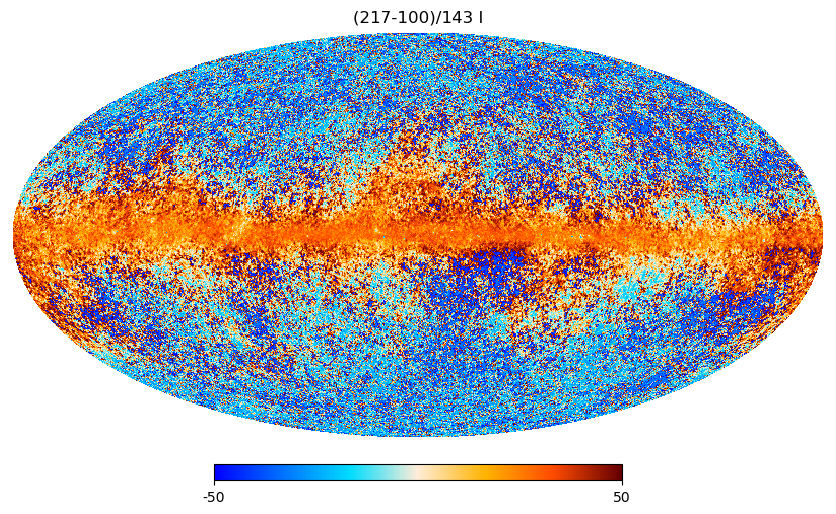

In [238]:
#read the planck map 100,143,217
map_100 = hp.read_map(map_100_file, field= (0,1,2))
map_143 = hp.read_map(map_143_file, field= (0,1,2))
map_217 = hp.read_map(map_217_file, field= (0,1,2))

#Performed the (217-100)/143 map
Map = (map_217-map_100)/map_143

hp.mollview(Map[0], norm = 'hist', cmap = Planck_cmap, min = -50, max = 50, title = '(217-100)/143 I')

<p style="font-size:150%;">Plot of the (217-100)/143 Planck Map highliting the 4 regions</p>

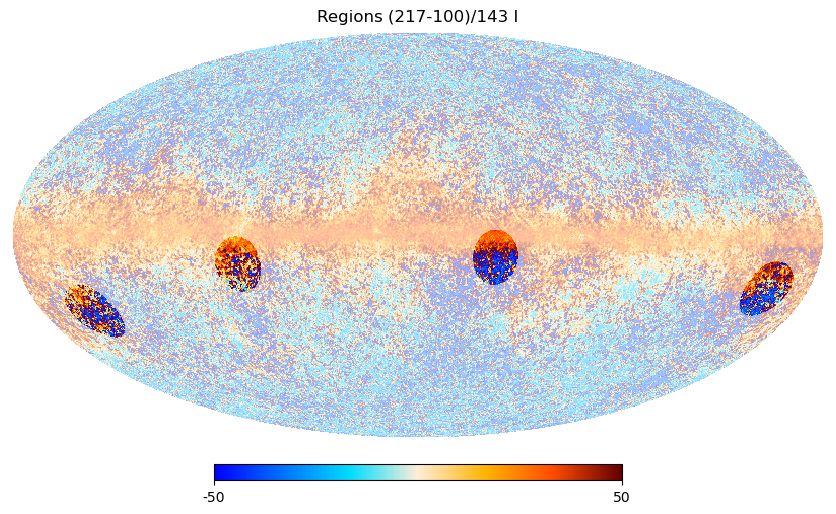

In [239]:
regions = []
disc = []
Alpha = np.ones(Map[0].size)*0.4


[ regions.append(hp.ang2vec(-sky_regions[i].b.rad+np.radians(90),sky_regions[i].l.rad)) for i in sky_regions ]

for i in range(4):
    disc = hp.query_disc(nside=2048,vec=regions[i], radius=np.radians(10))
    Alpha[disc] = 1

hp.mollview(Map[0], norm = 'hist', cmap = Planck_cmap, min = -50, max = 50, title = 'Regions (217-100)/143 I', alpha=Alpha,fig=i)




<p style="font-size:150%;">Coverage with realistic sweeping pointing strategy</p>

I perform the simulation of all the regions, with a realistic sweeping pointing strategy (My class Qubic Observation).

Fix the scanning dictionary parameters for the simulation

In [240]:
d['date_obs'] = '2023-01-01 10:00:00'
d['duration'] = 24 #h
d['angspeed'] = 1 #deg/s
d['delta_az'] = 20 #deg
d['nsweeps_per_elevation'] = 50

Create the cov Dict that containes the cov per each region per each frequency.

In [241]:
#I compute the coverage for just one frequency
pixel = hp.nside2npix(d['nside'])
real_covs = {\
             'left'        : np.ones(shape=(pixel)),
             'left-center' : np.ones(shape=(pixel)),
             'center-right': np.ones(shape=(pixel)),
             'right'       : np.ones(shape=(pixel))
             }
real_covs['left'].shape

(786432,)

In [ ]:
#Create a single band qubic instrument with all detectors (default)

q = QubicInstrument(d)

# Model of the scene at the time of observation

s = QubicScene(d)

#For each sky regions I compute first the pointing and then create the qubic Instrument

j=0

for i in sky_regions:

    d['RA_center'] = sky_regions[i].icrs.ra.value
    d['DEC_center'] = sky_regions[i].icrs.dec.value

    # Get pointing
    Obs = qobs.QubicObservation(d)
    p = Obs.get_pointing()
    #usually qubic.get_pointing()

    Time = Obs.DeltaTime(p.obstime)
    
    p = QubicSampling(azimuth = p.az.value, elevation = p.alt.value, time = Time, date_obs = p.obstime[0].value, longitude = Obs.earth_location.lon.value,latitude = Obs.earth_location.lat.value)

    p.fix_az = False

    #Create the Qubic Instr 
    a = QubicAcquisition(q, p, s, d)

    # Get coverage map
    # how many times were seen each pixel of the sky (not trivial because of the synthetic beam)
    real_covs[i] = a.get_coverage()
    j=j+1


executing: self.detarray = '/opt/homebrew/Cellar/micromamba/2.1.0/envs/MMQubic/lib/python3.9/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/opt/homebrew/Cellar/micromamba/2.1.0/envs/MMQubic/lib/python3.9/site-packages/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/opt/homebrew/Cellar/micromamba/2.1.0/envs/MMQubic/lib/python3.9/site-packages/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/opt/homebrew/Cellar/micromamba/2.1.0/envs/MMQubic/lib/python3.9/site-packages/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/opt/homebrew/Cellar/micromamba/2.1.0/envs/MMQubic/lib/python3.9/site-packages/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
******* With these parameters  7  recentering are performed ***********
Info Ismail.local: Allocating (4761600,9) elements = 653.90625 MiB in FSRRotation3dMatrix.__init__.
******* With these parameters  3  recentering are performed

<p style="font-size:150%;">Plot of the regions coverage</p>

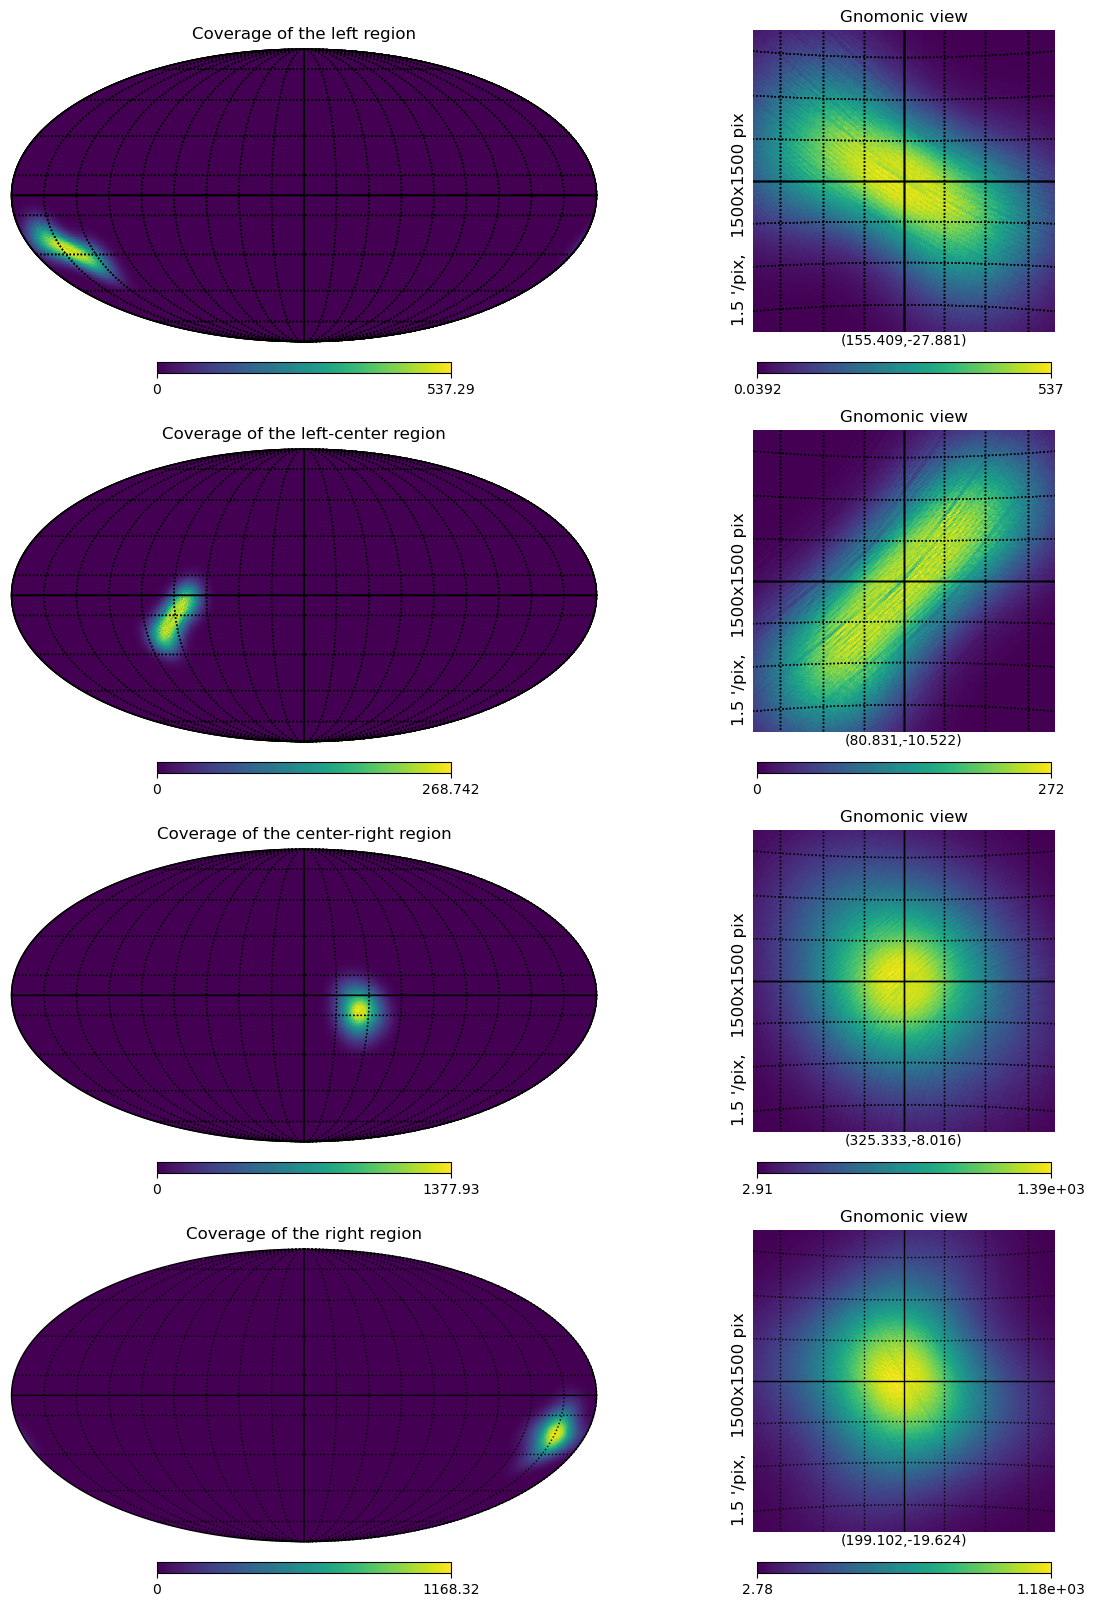

In [243]:
plt.figure(figsize=(12,16))
ireg = np.arange(len(real_covs))*2

j = 0
for i in real_covs:
    map_title = 'Coverage of the %s region' % (i)
    
    hp.mollview(real_covs[i],title = map_title,sub=(4,2,ireg[j]+1))
    hp.gnomview(real_covs[i],rot=(sky_regions[i].l.value,sky_regions[i].b.value),xsize=1500,sub=(4,2,ireg[j]+2))
    hp.graticule(5,5)
    j = j+1